# **<font color=#FF6600>Recruit Restaurant Visitor Forecasting</font>**
*Mihwa Han (Feb 2018)*
___

<img src="restaurant.jpg" width=500>

A long-time dream of mine is to run my own restaurant. I like to imagine introducing people to many unique recipes in a beautiful setting, and making people happy after a difficult day. 
After all, enjoying delicious food in the right environment can erase many of your troubles.
Many people likely have similar goals, but operating your own restaurant presents many difficult challenges. 

Maintaining an efficient operation requires an accurate forecast of how many customers you expect each day in your restaurant. You need to know how many staff members to have on hand, and how much food to prepare, which depends on how many customers you will see that day. However, the number of customers that visit your restaurant might depend on many factors, like the weather, nearby competitors, and local events.

In this posting, I will use data from Recruit Holdings (via [Kaggle](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting#timeline)), which includes visitor counts for hundreds of restaurants in Japan and relevent information about those restaurants.
Specifically, Recruit Holdings owns <font color='green'>Hot Pepper Gourmet</font> (a restaurant review service), <font color='green'>AirREGI</font>(a restaurant point of sales service), and Restaurant Board (reservation log management software). I will use these data to predict the number of visitors to the restaurants on future dates.
**This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers**. 

This notebook includes:

**0. Quick Overview with Tableau** <br>
**1. Load the data** <br>
**2. Overview: File structure** <br>
- 2.1 Air Store Location
- 2.2 Air Visit
    * 3.2.1 case 1: the ideal case
    * 3.2.2 case 2
- 2.3 Air Reservations && Hpg Reservations
- 2.4 Holiday

**3. Feature Engineering** <br>
- 3.1 A global view of all *air* restaurants
- 3.2 A spot check
    * 3.2.1 case 1: the ideal case
    * 3.2.2 case 2
- 3.3 Test set reservations

**4. Model** <br>
**5. Conclusion** <br>
___

</n>
## 0. Quick Overview with Tableau
___

The plots below is a simple overview of data which includes locations, genres, popular hours, numbers of the restaurants I plotted them using [Tableau](https://www.tableau.com/).
<img src="tableau.png" width=1000>

</n>
## 1. Load  Libraries & the data
___

In [1]:
import glob, re
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor
import h2o
from xgboost.sklearn import XGBRegressor  
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns

/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  

In [2]:
air_visit = pd.read_csv('../input/air_visit_data.csv')
air_store = pd.read_csv('../input/air_store_info.csv')
hpg_store = pd.read_csv('../input/hpg_store_info.csv')
air_reserve = pd.read_csv('../input/air_reserve.csv')
hpg_reserve = pd.read_csv('../input/hpg_reserve.csv')
store_id = pd.read_csv('../input/store_id_relation.csv')
holiday = pd.read_csv('../input/date_info.csv').rename(columns={'calendar_date':'visit_date'})
sub = pd.read_csv('../input/sample_submission.csv')

For these various dataframes, the meaning of the variables is given on the [competition home page](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data). 
- **air_reserve.csv, hpg_reserve.csv**: reservations made in the air (*AirREGI*) or hpg (*Hot Pepper Gourmet*) systems
- **air_store_info.csv, hpg_store_info.csv**: information about *air* and *hpg* restaurants
- **store_id_relation.csv**: link the restaurants ids of the air and hpg systems
- **air_visit_data.csv**: historical visit data for the air restaurants
- **date_info.csv**: information about the calendar dates in the dataset


## 2. Overview: File structure 
___

## 2.1 Air Store Location
___

Where are the stores located? The code below is refered by FabrienDaniel's code from Kaggle([Here](https://www.kaggle.com/fabiendaniel/recruit-restaurant-eda))


/Users/ryan/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3302: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/ryan/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3311: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/ryan/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3266: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/ryan/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3275: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0.5,1.05,'air store restaurant locations')

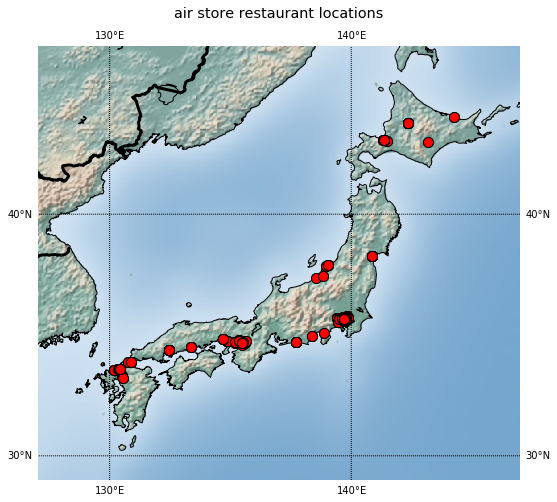

In [3]:
plt.figure(figsize=(15,8))
map = Basemap(resolution='i',llcrnrlon=127, urcrnrlon=147,llcrnrlat=29, urcrnrlat=47, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
parallels = np.arange(0.,360,10.,)
map.drawparallels(parallels, labels = [True for s in range(len(parallels))])
meridians = np.arange(0.,360,10.,)
map.drawmeridians(meridians, labels = [True for s in range(len(meridians))])
for index, (y,x) in air_store[['latitude','longitude']].iterrows():
    x, y = map(x, y)
    map.plot(x, y, marker='o', markersize = 10, markeredgewidth = 1, color = 'red',markeredgecolor='k')
plt.title('air store restaurant locations', y = 1.05)

In [4]:
air_store.head(1)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852


In [5]:
hpg_store.head(1)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


Text(0,0.5,'Number')

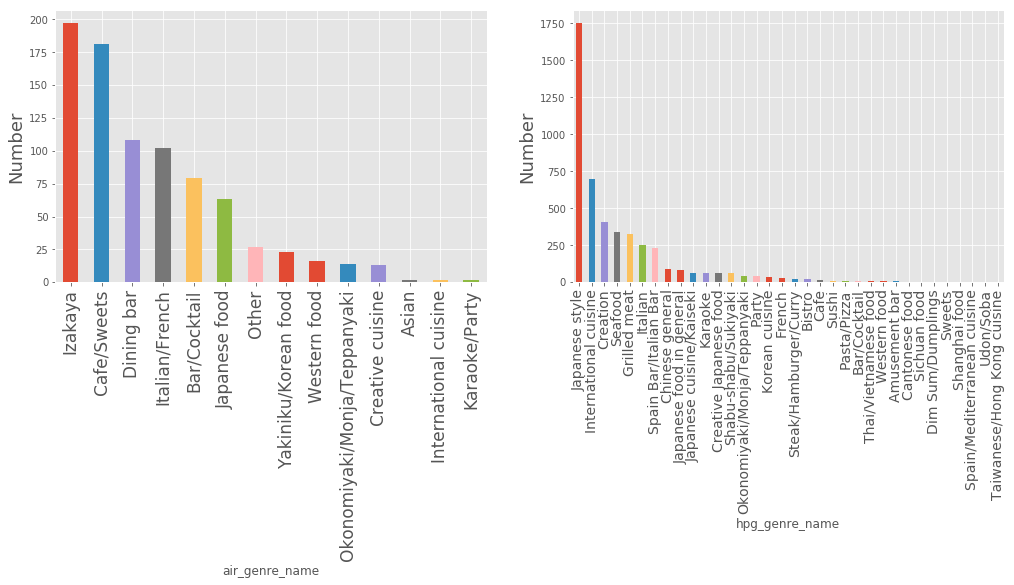

In [6]:
fig = plt.figure(figsize=(17,5))
ax = fig.add_subplot(121)
temp = air_store.groupby("air_genre_name").count()['air_store_id'].sort_values(ascending=False)
temp.plot(kind='bar',width=0.5,ax=ax)
ax.set_xticklabels(temp.sort_values(ascending=False).index,fontsize=17)
plt.ylabel("Number",fontsize=18)

ax = fig.add_subplot(122)
temp = hpg_store.groupby("hpg_genre_name").count()['hpg_store_id'].sort_values(ascending=False)
temp.plot(kind='bar',width=0.5,ax=ax)
ax.set_xticklabels(temp.sort_values(ascending=False).index,fontsize=14)
plt.ylabel("Number",fontsize=18)

In [7]:
print("Total Number of Area names : {}".format(len(air_store.groupby("air_area_name").count())))
print("Total Number of Area names : {}".format(len(hpg_store.groupby("hpg_area_name").count())))

Total Number of Area names : 103
Total Number of Area names : 119


## 2.2 Air Visits
___
I plot the total visitors and average visitors over days for all stores. 

In [8]:
air_visit.head(1)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25


In [9]:
air_visit['visit_date']=pd.to_datetime(air_visit['visit_date'])

Text(0,0.5,'Ave(visitors)')

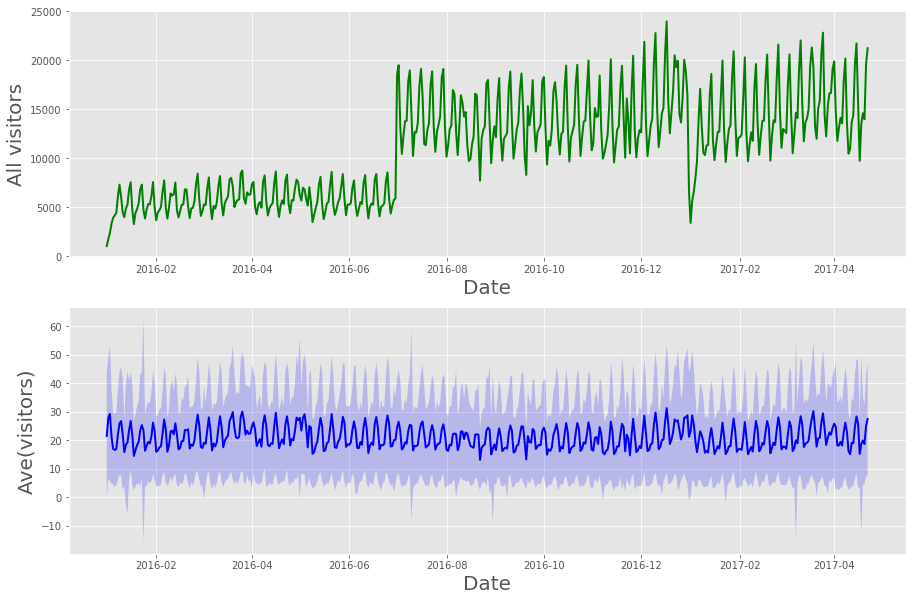

In [10]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
temp = air_visit.groupby(['visit_date']).sum()
ax1.plot(temp,'green',linewidth=2)
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('All visitors',fontsize=20)

ax2 = fig.add_subplot(212)
temp = air_visit.groupby(['visit_date']).mean()
ax2.plot(temp.index,temp.values,'blue',linewidth=2)
error = air_visit.groupby(['visit_date']).std()
ax2.fill_between(temp.index,(temp.values-error.values).T[0], (temp.values+error.values).T[0],
                facecolor='blue', alpha=0.2)
ax2.set_xlabel('Date',fontsize=20)
ax2.set_ylabel('Ave(visitors)',fontsize=20)

I find:
- There is a large difference before "2016-07" and after "2016-07". However, overall visitors are similar based on the bottom figure. Why? Maybe there are more stores after the days?

In [11]:
print("Total Number of Restaurants : {}".format(len(air_visit.groupby("air_store_id").count())))

Total Number of Restaurants : 829


Yes. The dataset include a lot less data of restaurants' visits information.

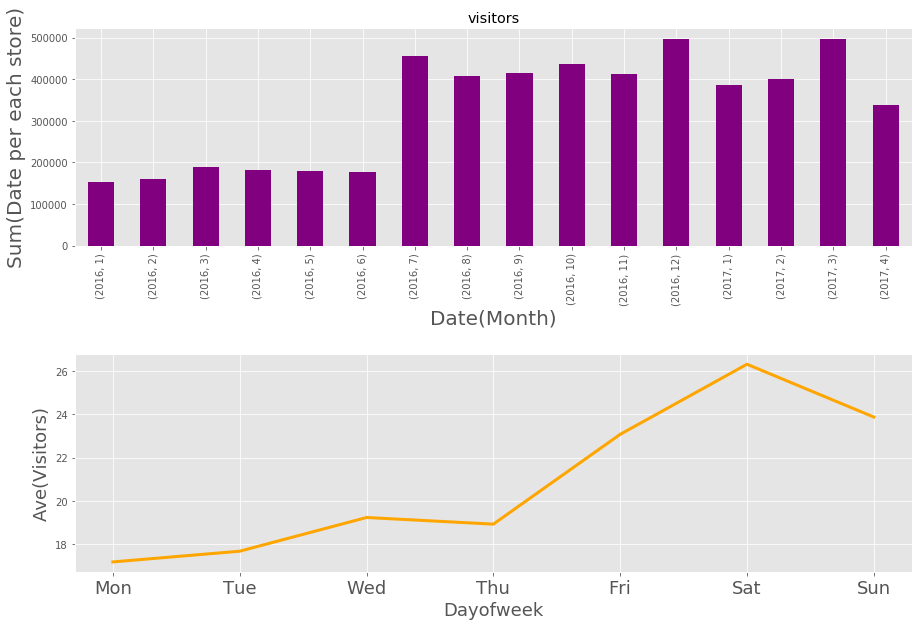

In [12]:
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
t = air_visit.groupby([(air_visit.visit_date.dt.year),(air_visit.visit_date.dt.month)]).sum()['visitors']
t.plot(kind='bar',width=0.5,figsize=(10,5),legend=None,subplots=True,ax=ax1,title=None,color='purple')
plt.xlabel("Date(Month)",fontsize=20)
plt.ylabel("Sum(Date per each store)",fontsize=20)

ax2 = fig.add_subplot(212)
air_visit["dayofweek"] = air_visit.visit_date.dt.dayofweek
day_p=air_visit.groupby("dayofweek").mean()['visitors']
day_p.plot(kind='line',color='orange', figsize=(10,5),legend=None,subplots=True,ax=ax2,use_index=False,linewidth=3)
#plt.ylim(15,25)
plt.ylabel("Ave(Visitors)",fontsize=18)
plt.xlabel("Dayofweek",fontsize=18)
ax2.set_xticklabels(['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=18)
plt.subplots_adjust(wspace=0.1, hspace=0.5)

Text(0,0.5,'Ave(Visitors)')

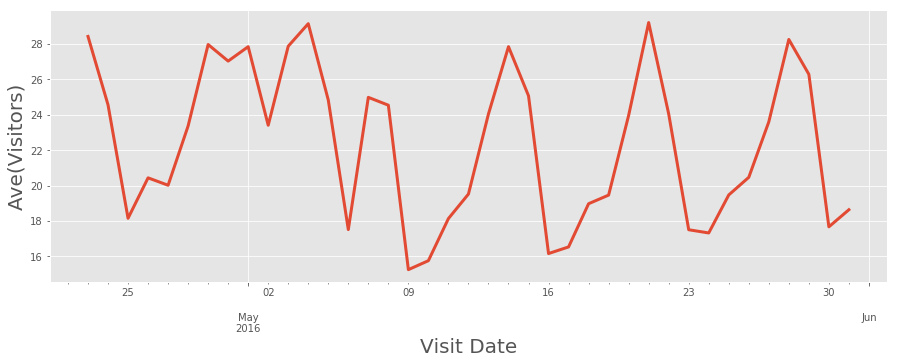

In [13]:
sub1 = air_visit[(air_visit.visit_date>='2016-04-23') & (air_visit.visit_date<='2016-05-31')]
temp = sub1.groupby(['visit_date']).mean()[['visitors','dayofweek']]
temp['visitors'].plot(kind='line',figsize=(15,5),legend=None,title=None,linewidth=3)
plt.xlabel("Visit Date",fontsize=20)
plt.ylabel("Ave(Visitors)",fontsize=20)

## 2.3 Air Reservations && Hpg Reservations
___

In [14]:
air_reserve.head(1)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1


In [15]:
hpg_reserve.head(1)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1


In [16]:
air_reserve['visit_datetime']=pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['reserve_datetime']=pd.to_datetime(air_reserve['reserve_datetime'])
air_reserve['visit_hour']=air_reserve['visit_datetime'].dt.hour
air_reserve['reserve_hour']=air_reserve['reserve_datetime'].dt.hour

hpg_reserve['visit_datetime']=pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['reserve_datetime']=pd.to_datetime(hpg_reserve['reserve_datetime'])
hpg_reserve['visit_hour']=hpg_reserve['visit_datetime'].dt.hour
hpg_reserve['reserve_hour']=hpg_reserve['reserve_datetime'].dt.hour

(0, 730000)

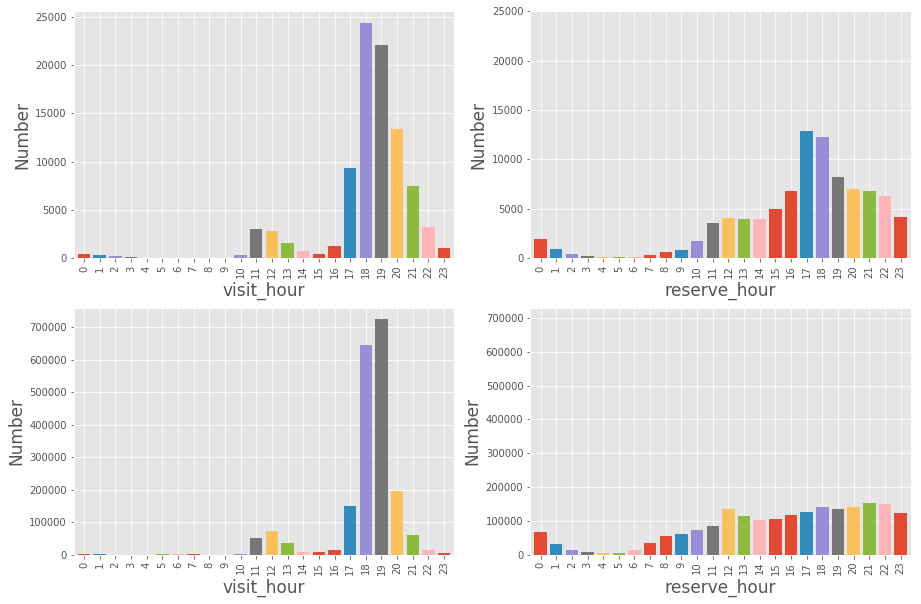

In [17]:
fig = plt.figure(figsize=(15,10))
ax=fig.add_subplot(221)
air_reserve.groupby("visit_hour").count()['reserve_visitors'].plot(kind='bar',width=0.8,ax=ax)
plt.xlabel("visit_hour",fontsize=17)
plt.ylabel("Number",fontsize=17)

ax2=fig.add_subplot(222)
air_reserve.groupby("reserve_hour").count()['reserve_visitors'].plot(kind='bar',width=0.8,ax=ax2)
plt.xlabel("reserve_hour",fontsize=17)
plt.ylabel("Number",fontsize=17)
plt.ylim(0,25000)

ax3=fig.add_subplot(223)
hpg_reserve.groupby("visit_hour").count()['reserve_visitors'].plot(kind='bar',width=0.8,ax=ax3)
plt.xlabel("visit_hour",fontsize=17)
plt.ylabel("Number",fontsize=17)

ax4=fig.add_subplot(224)
hpg_reserve.groupby("reserve_hour").count()['reserve_visitors'].plot(kind='bar',width=0.8,ax=ax4)
plt.xlabel("reserve_hour",fontsize=17)
plt.ylabel("Number",fontsize=17)
plt.ylim(0,730000)

## 2.4 Holiday

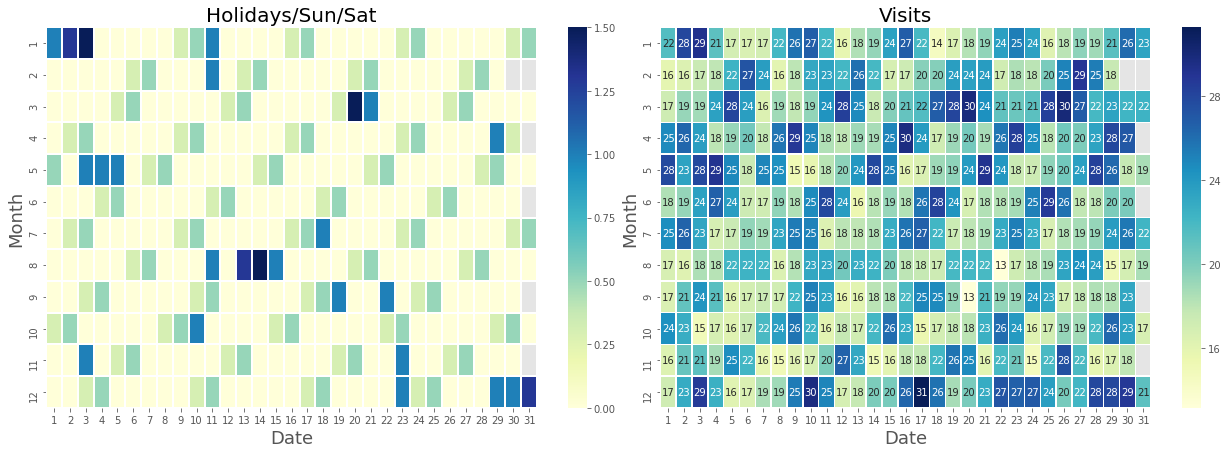

In [18]:
holiday['visit_date'] = pd.to_datetime(holiday['visit_date'])
holiday['month'] = holiday['visit_date'].dt.month 
holiday['date'] = holiday['visit_date'].dt.day

holiday['sunday'] = holiday['visit_date'].dt.dayofweek.apply(lambda x:1 if x==6 else 0)
holiday['saturday'] = holiday['visit_date'].dt.dayofweek.apply(lambda x:1 if x==5 else 0)
holiday['sat/sun/hol']=holiday['holiday_flg']*1+holiday['sunday']*0.5+holiday['saturday']*0.3

holiday2016 = holiday[holiday['visit_date'].dt.year==2016]
holiday2017 = holiday[holiday['visit_date'].dt.year==2017]

air_visit['month'] = air_visit['visit_date'].dt.month 
air_visit['date'] = air_visit['visit_date'].dt.day
air_visit2016 = air_visit[air_visit['visit_date'].dt.year==2016]
air_visit2017 = air_visit[air_visit['visit_date'].dt.year==2017]

holiday['sat/sun/hol']=holiday['holiday_flg']*1+holiday['sunday']*0.5+holiday['saturday']*0.3

tb1=pd.pivot_table(holiday2016,values='sat/sun/hol',index=['month'],columns=['date'])
tb2=pd.pivot_table(air_visit2016,values='visitors',index=['month'],columns=['date'])

fig=plt.figure(figsize=(22,7))
ax1 = fig.add_subplot(121)
sns.heatmap(tb1,cmap="YlGnBu",linewidths='1',ax=ax1)
plt.title("Holidays/Sun/Sat",fontsize=20)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Month",fontsize=18)

ax2 = fig.add_subplot(122)
sns.heatmap(tb2,annot=True, cmap="YlGnBu",linewidths='0.5',ax=ax2)
plt.title("Visits",fontsize=20)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Month",fontsize=18)
fig.subplots_adjust(wspace=0.001)

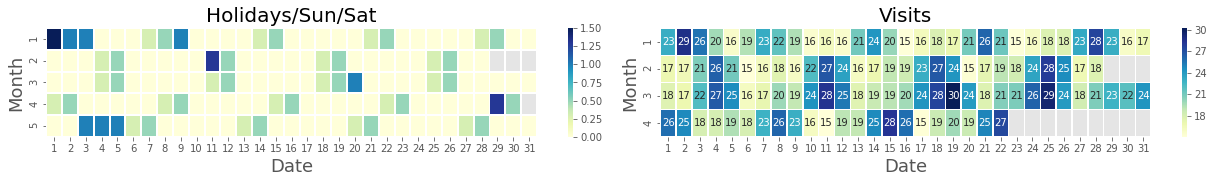

In [19]:
tb1=pd.pivot_table(holiday2017,values='sat/sun/hol',index=['month'],columns=['date'])
tb2=pd.pivot_table(air_visit2017,values='visitors',index=['month'],columns=['date'])

fig=plt.figure(figsize=(22,2))
ax1 = fig.add_subplot(121)
sns.heatmap(tb1,cmap="YlGnBu",linewidths='1',ax=ax1)
plt.title("Holidays/Sun/Sat",fontsize=20)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Month",fontsize=18)

ax2 = fig.add_subplot(122)
sns.heatmap(tb2,annot=True, cmap="YlGnBu",linewidths='0.5',ax=ax2)
plt.title("Visits",fontsize=20)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Month",fontsize=18)
fig.subplots_adjust(wspace=0.001)

## 3. Feature Engineering

For Machine learning, we need to do feature engineering. The bottom of the code is strongly refered by one of popular kernels in the kaggle competition[This Kernel](https://www.kaggle.com/tunguz/surprise-me-2/code).

In [125]:
## 1. load data files
air_visit = pd.read_csv('../input/air_visit_data.csv')
air_store = pd.read_csv('../input/air_store_info.csv')
hpg_store = pd.read_csv('../input/hpg_store_info.csv')
air_reserve = pd.read_csv('../input/air_reserve.csv')
hpg_reserve = pd.read_csv('../input/hpg_reserve.csv')
store_id = pd.read_csv('../input/store_id_relation.csv')
holiday = pd.read_csv('../input/date_info.csv').rename(columns={'calendar_date':'visit_date'})
sub = pd.read_csv('../input/sample_submission.csv')

## 2. Create New columns - reserved datetime difference, sum of reserved visitors

hpg_reserve = pd.merge(hpg_reserve, store_id, how='inner', on=['hpg_store_id'])

air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['visit_datetime'] = air_reserve['visit_datetime'].dt.date
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'])
air_reserve['reserve_datetime'] = air_reserve['reserve_datetime'].dt.date
air_reserve['reserve_datetime_diff'] = air_reserve.apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
tmp1 = air_reserve.groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs_sum', 'reserve_visitors':'rv_sum'})
tmp2 = air_reserve.groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs_mean', 'reserve_visitors':'rv_mean'})
air_reserve = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['visit_datetime'] = hpg_reserve['visit_datetime'].dt.date
hpg_reserve['reserve_datetime'] = pd.to_datetime(hpg_reserve['reserve_datetime'])
hpg_reserve['reserve_datetime'] = hpg_reserve['reserve_datetime'].dt.date
hpg_reserve['reserve_datetime_diff'] = hpg_reserve.apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
tmp1 = hpg_reserve.groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs_sum', 'reserve_visitors':'rv_sum'})
tmp2 = hpg_reserve.groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs_mean', 'reserve_visitors':'rv_mean'})
hpg_reserve = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

## 3. Create New columns - year, month, day of week, date for train/test data

air_visit['visit_date'] = pd.to_datetime(air_visit['visit_date'])
air_visit['day'] = air_visit['visit_date'].dt.dayofweek
air_visit['year'] = air_visit['visit_date'].dt.year
air_visit['month'] = air_visit['visit_date'].dt.month
air_visit['date'] = air_visit['visit_date'].dt.day

sub['visit_date'] = sub['id'].map(lambda x: str(x).split('_')[2])
sub['air_store_id'] = sub['id'].map(lambda x: '_'.join(x.split('_')[:2]))
sub['visit_date'] = pd.to_datetime(sub['visit_date'])
sub['day'] = sub['visit_date'].dt.dayofweek
sub['year'] = sub['visit_date'].dt.year
sub['month'] = sub['visit_date'].dt.month
sub['date'] = sub['visit_date'].dt.day

air_visit = pd.merge(air_visit, air_store, how='left', on=['air_store_id']) 

## 4. Create New columns - min/mean/median/max/count/variation values of each store for each day of week

unique_stores = sub['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'day': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

tmp = air_visit.groupby(['air_store_id','day'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','day']) 

tmp = air_visit.groupby(['air_store_id','day'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','day'])

tmp = air_visit.groupby(['air_store_id','day'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','day'])

tmp = air_visit.groupby(['air_store_id','day'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','day'])

tmp = air_visit.groupby(['air_store_id','day'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','day']) 

tmp = air_visit.groupby(['air_store_id','day'], as_index=False)['visitors'].var().rename(columns={'visitors':'var_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','day']) 

stores = pd.merge(stores, air_visit, how='left', on=['air_store_id']) 

## 4. LabelEncoder for genre name and area name

stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(4):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name' +str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))

stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

## 5. merge with holiday data

holiday['visit_date'] = pd.to_datetime(holiday['visit_date'])
holiday['day_of_week'] = lbl.fit_transform(holiday['day_of_week'])

train = pd.merge(air_visit, holiday, how='left', on=['visit_date']) 
test = pd.merge(sub, holiday, how='left', on=['visit_date']) 
train.drop(['latitude','longitude'], axis=1, inplace=True)

## 6. merge with all other data

train = pd.merge(train, stores, how='left', on=['air_store_id','visit_date']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','visit_date'])

train = pd.merge(train, air_reserve, how='left', on=['air_store_id','visit_date']) 
test = pd.merge(test, air_reserve, how='left', on=['air_store_id','visit_date'])

train = pd.merge(train, hpg_reserve, how='left', on=['air_store_id','visit_date']) 
test = pd.merge(test, hpg_reserve, how='left', on=['air_store_id','visit_date']) 

## 7. Create New feature - difference with between max longitude/latitude

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

train = train.fillna(-999)
test = test.fillna(-999)

## 4. Modeling

In [139]:
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date_x','visitors_y','visit_date','air_genre_name_x','air_area_name_x']]
X = train[col]
y = np.log1p(train['visitors_x'].values)

X_train = train[train.visit_date<'2017-03-01'][col]
X_valid = train[train.visit_date>='2017-03-01'][col]

y_train = np.log1p(train[train.visit_date<'2017-03-01']['visitors_x'].values)
y_valid = np.log1p(train[train.visit_date>='2017-03-01']['visitors_x'].values)

X_train_2 = train[(train.visit_date<='2016-04-22') & (train.visit_date>='2016-03-01')][col]
y_train_2 = np.log1p(train[(train.visit_date<='2016-04-22') & (train.visit_date>='2016-03-01')]['visitors_x'].values)

In [140]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)
params = {  
    "n_estimators": st.randint(10, 200),
    "max_depth": st.randint(3, 10),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}
xgbreg = XGBRegressor(nthreads=-1)  

model1 = RandomizedSearchCV(xgbreg, params, n_jobs=1)   
model2 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=250, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =10)
model3 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, 
                      max_depth =10)
model4 = RandomizedSearchCV(xgbreg, params, n_jobs=1)   
model5 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=250, subsample=0.8, 
                     colsample_bytree=0.8, max_depth =10)
model6 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, 
                      max_depth =10)

In [141]:
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train_2, y_train_2)
model5.fit(X_train_2, y_train_2)
model6.fit(X_train_2, y_train_2)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=3,
             subsample=0.8, verbose=0, warm_start=False)

In [142]:
## prediction
preds1 = model1.predict(X_valid)
preds2 = model2.predict(X_valid)
preds3 = model3.predict(X_valid)
preds4 = model4.predict(X_valid)
preds5 = model5.predict(X_valid)
preds6 = model6.predict(X_valid)

print('RMSE XGBRegressor 1: ', RMSLE(y_valid, preds1))
print('RMSE XGBRegressor 2: ', RMSLE(y_valid, preds2))
print('RMSE GradientBoostong: ', RMSLE(y_valid, preds3))
print('RMSE XGBRegressor 1(part): ', RMSLE(y_valid, preds4))
print('RMSE XGBRegressor 2(part): ', RMSLE(y_valid, preds5))
print('RMSE GradientBoostong(part): ', RMSLE(y_valid, preds6))

RMSE XGBRegressor 1:  0.015182763050072419
RMSE XGBRegressor 2:  0.013982028961721299
RMSE GradientBoostong:  0.002344786965093593
RMSE XGBRegressor 1(part):  0.015228387231841401
RMSE XGBRegressor 2(part):  0.030239217094138238
RMSE GradientBoostong(part):  0.010885583451528092


</n>
## 5. Conclusion
___

We can aggregate different models above to create a new model. 